In [7]:
# Previsão com Redes Neurais - CRISP-DM passo a passo (generalizado)

# Importação das bibliotecas necessárias para manipulação de arquivos

import glob # Biblioteca para encontrar arquivos usando padrões
import os # Biblioteca para operações do sistema operacional

# Importações do TensorFlow/Keras para deep learning

from tensorflow.keras.callbacks import EarlyStopping # Callback para parar treinamento quando não há melhoria
from tensorflow.keras.layers import Dense, LSTM # Camadas para construção da rede neural
from tensorflow.keras.models import Sequential # Modelo sequencial do Keras

# Importações do scikit-learn para pré-processamento e métricas

from sklearn.preprocessing import MinMaxScaler # Normalizador de dados entre 0 e 1
from sklearn.metrics import mean_squared_error, mean_absolute_error # Métricas de avaliação

# Importações para visualização de dados

import seaborn as sns # Biblioteca para visualizações estatísticas
import matplotlib.pyplot as plt # Biblioteca principal de plotagem

# Importações para manipulação de dados

import numpy as np # Biblioteca para computação numérica
import pandas as pd # Biblioteca para manipulação de dados tabulares

In [8]:
# 1. Data Understanding - Leitura dos dados
files = glob.glob(os.path.join("./Dados", "*.csv"))    # Lista todos os arquivos CSV no diretório
all_dataframes = []                                    # Lista para armazenar todos os dataframes

# Loop através de cada arquivo encontrado
for file in files:
    try:
        # Abre o arquivo para leitura das informações de cabeçalho
        with open(file, "r", encoding="latin1") as f:
            linhas = f.readlines()                     # Lê todas as linhas do arquivo
            # Extrai informações geográficas do cabeçalho
            latitude = linhas[4].split(";")[1].strip() # Extrai latitude
            longitude = linhas[5].split(";")[1].strip()# Extrai longitude
            altura = linhas[6].split(";")[1].strip()   # Extrai altura

        # Lê o arquivo CSV com pandas, pulando o cabeçalho
        dataframe = pd.read_csv(file,
                              delimiter=";",           # Define separador
                              skiprows=8,             # Pula linhas de cabeçalho
                              encoding="latin1",      # Define encoding
                              decimal=",")            # Define separador decimal

        # Padronização dos nomes das colunas
        if "Data" in dataframe.columns:
            dataframe.rename(columns={"Data": "DATA (YYYY-MM-DD)"}, inplace=True)
        if "Hora UTC" in dataframe.columns:
            dataframe.rename(columns={"Hora UTC": "HORA (UTC)"}, inplace=True)
        if "RADIACAO GLOBAL (Kj/m²)" in dataframe.columns:
            dataframe.rename(columns={"RADIACAO GLOBAL (Kj/m²)": "RADIACAO GLOBAL (KJ/m²)"},
                           inplace=True)

        # Adiciona metadados como colunas
        dataframe[["Latitude", "Longitude", "Altura", "File"]] = [
            latitude, longitude, altura, file]

        # Adiciona o dataframe à lista
        all_dataframes.append(dataframe)

    except UnicodeDecodeError:
        continue    # Ignora arquivos com problemas de encoding
    except Exception as e:
        print(f"Erro ao ler {file}: {str(e)}")    # Registra outros erros
        continue

# Concatena todos os dataframes em um único
df = pd.concat(all_dataframes, ignore_index=True)

In [9]:
# Definição das colunas que serão usadas como features
features_columns = [
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',              # Precipitação total por hora
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)', # Pressão atmosférica
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',      # Pressão máxima anterior
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',     # Pressão mínima anterior
    'RADIACAO GLOBAL (KJ/m²)',                              # Radiação solar global
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',         # Temperatura do ar
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',                 # Temperatura de orvalho
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',          # Temperatura máxima anterior
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',          # Temperatura mínima anterior
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',    # Temperatura orvalho máxima
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',    # Temperatura orvalho mínima
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',           # Umidade relativa máxima
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',           # Umidade relativa mínima
    'UMIDADE RELATIVA DO AR, HORARIA (%)',                # Umidade relativa atual
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))',              # Direção do vento
    'VENTO, RAJADA MAXIMA (m/s)',                        # Velocidade máxima do vento
    'VENTO, VELOCIDADE HORARIA (m/s)',                   # Velocidade média do vento
]

# Definição da coluna alvo (target) e parâmetros do modelo
target_column = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'  # Variável a ser prevista
window_size = 24  # Tamanho da janela de tempo (24 horas)
epochs = 50      # Número de épocas para treinamento

In [10]:
# 2. Data Preparation - Tratamento dos dados

# Corrigir formatos de data e hora e criar coluna datetime
df.loc[df["HORA (UTC)"].str.contains("UTC"), "DATA (YYYY-MM-DD)"] = df.loc[df["HORA (UTC)"]
    .str.contains("UTC"), "DATA (YYYY-MM-DD)"].str.replace("/", "-")  # Padroniza formato da data

# Formata a hora para padrão HH:MM
df.loc[df["HORA (UTC)"].str.contains("UTC"), "HORA (UTC)"] = df.loc[df["HORA (UTC)"]
    .str.contains("UTC"), "HORA (UTC)"].apply(lambda x: f"{x[:2]}:{x[2:4]}")

# Cria coluna datetime combinando data e hora
df["DATA_HORA"] = pd.to_datetime(df["DATA (YYYY-MM-DD)"] + " " + df["HORA (UTC)"])

# Remove colunas originais de data e hora
cols_to_drop = ["DATA (YYYY-MM-DD)", "HORA (UTC)"]
for col in cols_to_drop:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)

# Ordena o DataFrame por data/hora
df = df.sort_values('DATA_HORA').reset_index(drop=True)

In [11]:
def fix_temperature_outliers(df, column_name, outlier_value=-9999.000, window_size=24):
    """
    Corrige outliers em série temporal usando janelas móveis adaptativas.
    """
    # Cria cópia da série para não modificar dados originais
    temp_series = df[column_name].copy()

    # Identifica índices com outliers
    outlier_indices = temp_series[temp_series == outlier_value].index

    # Processa cada outlier encontrado
    for idx in outlier_indices:
        window_multiplier = 1
        replacement_value = None

        # Loop para encontrar valores válidos expandindo a janela
        while replacement_value is None and window_multiplier <= 7:  # Limite: 7 dias
            # Calcula tamanho da janela atual
            current_window = window_size * window_multiplier

            # Define limites da janela
            start_idx = max(0, idx - current_window)
            end_idx = min(len(temp_series), idx + current_window + 1)

            # Obtém valores da janela atual
            window_values = temp_series[start_idx:end_idx]

            # Remove outliers da janela
            valid_values = window_values[window_values != outlier_value]

            # Calcula média se houver valores válidos suficientes
            if len(valid_values) >= 3:
                replacement_value = valid_values.mean()
            else:
                window_multiplier += 1

        # Se não encontrou valores válidos, usa média global
        if replacement_value is None:
            replacement_value = temp_series[temp_series != outlier_value].mean()

        # Substitui o outlier
        temp_series[idx] = replacement_value

    return temp_series

def apply_temperature_correction(df, temperature_column):
    """
    Aplica correção de outliers no DataFrame
    """
    # Cria cópia do DataFrame
    df_corrected = df.copy()

    # Aplica correção de outliers na coluna especificada
    df_corrected[temperature_column] = fix_temperature_outliers(
        df_corrected, temperature_column, outlier_value=-9999.000, window_size=24
    )
    return df_corrected

# Aplica correção em todas as colunas de features
for column in features_columns:
    df = apply_temperature_correction(df, column)

In [12]:
# Dicionário de mapeamento para novos nomes de colunas
columns = {
    # Data e hora da coleta
    'DATA_HORA': 'DATA', 
    # Precipitação total por hora
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'PRECIPITACAO_TOTAL_mm',
    # Pressão atmosférica
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'PRESSAO_ATMOSFERICA_ESTACAO_mb',
    # Pressão máxima anterior
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'PRESSAO_ATMOSFERICA_MAX_HORA_ANT_mb',
    # Pressão mínima anterior
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'PRESSAO_ATMOSFERICA_MIN_HORA_ANT_mb',
    # Radiação solar global
    'RADIACAO GLOBAL (KJ/m²)': 'RADIACAO_GLOBAL_KJ_m2',
    # Temperatura do ar
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'TEMPERATURA_BULBO_SECO_C',
    # Temperatura de orvalho
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'TEMPERATURA_PONTO_ORVALHO_C',
    # Temperatura máxima anterior
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'TEMPERATURA_MAX_HORA_ANT_C',
    # Temperatura mínima anterior
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'TEMPERATURA_MIN_HORA_ANT_C',
    # Temperatura orvalho máxima
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'TEMPERATURA_ORVALHO_MAX_HORA_ANT_C',
    # Temperatura orvalho mínima
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'TEMPERATURA_ORVALHO_MIN_HORA_ANT_C',
    # Umidade relativa máxima
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'UMIDADE_REL_MAX_HORA_ANT',
    # Umidade relativa mínima
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'UMIDADE_REL_MIN_HORA_ANT',
    # Umidade relativa atual
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'UMIDADE_RELATIVA_HORARIA',
    # Direção do vento
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'VENTO_DIRECAO_HORARIA_GR',
    # Velocidade máxima do vento
    'VENTO, RAJADA MAXIMA (m/s)': 'VENTO_RAJADA_MAXIMA_MS',
    # Velocidade média do vento
    'VENTO, VELOCIDADE HORARIA (m/s)': 'VENTO_VELOCIDADE_HORARIA_MS',
    # Latitude da estação
    'Latitude': 'LATITUDE',
    # Longitude da estação
    'Longitude': 'LONGITUDE',
    # Altura da estação
    'Altura': 'ALTURA',
    # nome do arquivo
    'File': 'FILE'
}

# Aplica renomeação das colunas
df.rename(columns=columns, inplace=True)

# Remove coluna não utilizada
df.drop(columns='Unnamed: 19', inplace=True)

# Atualiza lista de features com novos nomes
features_columns = df.columns[:-5]
target_column = 'TEMPERATURA_BULBO_SECO_C'

# Salva dados processados
df.to_csv('Dados_sem_outliers.csv', index=False, sep=";")

In [13]:
df_analyses = df[['PRECIPITACAO_TOTAL_mm',
        'PRESSAO_ATMOSFERICA_ESTACAO_mb',
        'PRESSAO_ATMOSFERICA_MAX_HORA_ANT_mb',
        'PRESSAO_ATMOSFERICA_MIN_HORA_ANT_mb',
        'RADIACAO_GLOBAL_KJ_m2',
        'TEMPERATURA_BULBO_SECO_C',
        'TEMPERATURA_PONTO_ORVALHO_C',
        'TEMPERATURA_MAX_HORA_ANT_C',
        'TEMPERATURA_MIN_HORA_ANT_C',
        'TEMPERATURA_ORVALHO_MAX_HORA_ANT_C',
        'TEMPERATURA_ORVALHO_MIN_HORA_ANT_C',
        'UMIDADE_REL_MAX_HORA_ANT',
        'UMIDADE_REL_MIN_HORA_ANT',
        'UMIDADE_RELATIVA_HORARIA',
        'VENTO_DIRECAO_HORARIA_GR',
        'VENTO_RAJADA_MAXIMA_MS',
        'VENTO_VELOCIDADE_HORARIA_MS',
        ]].copy()

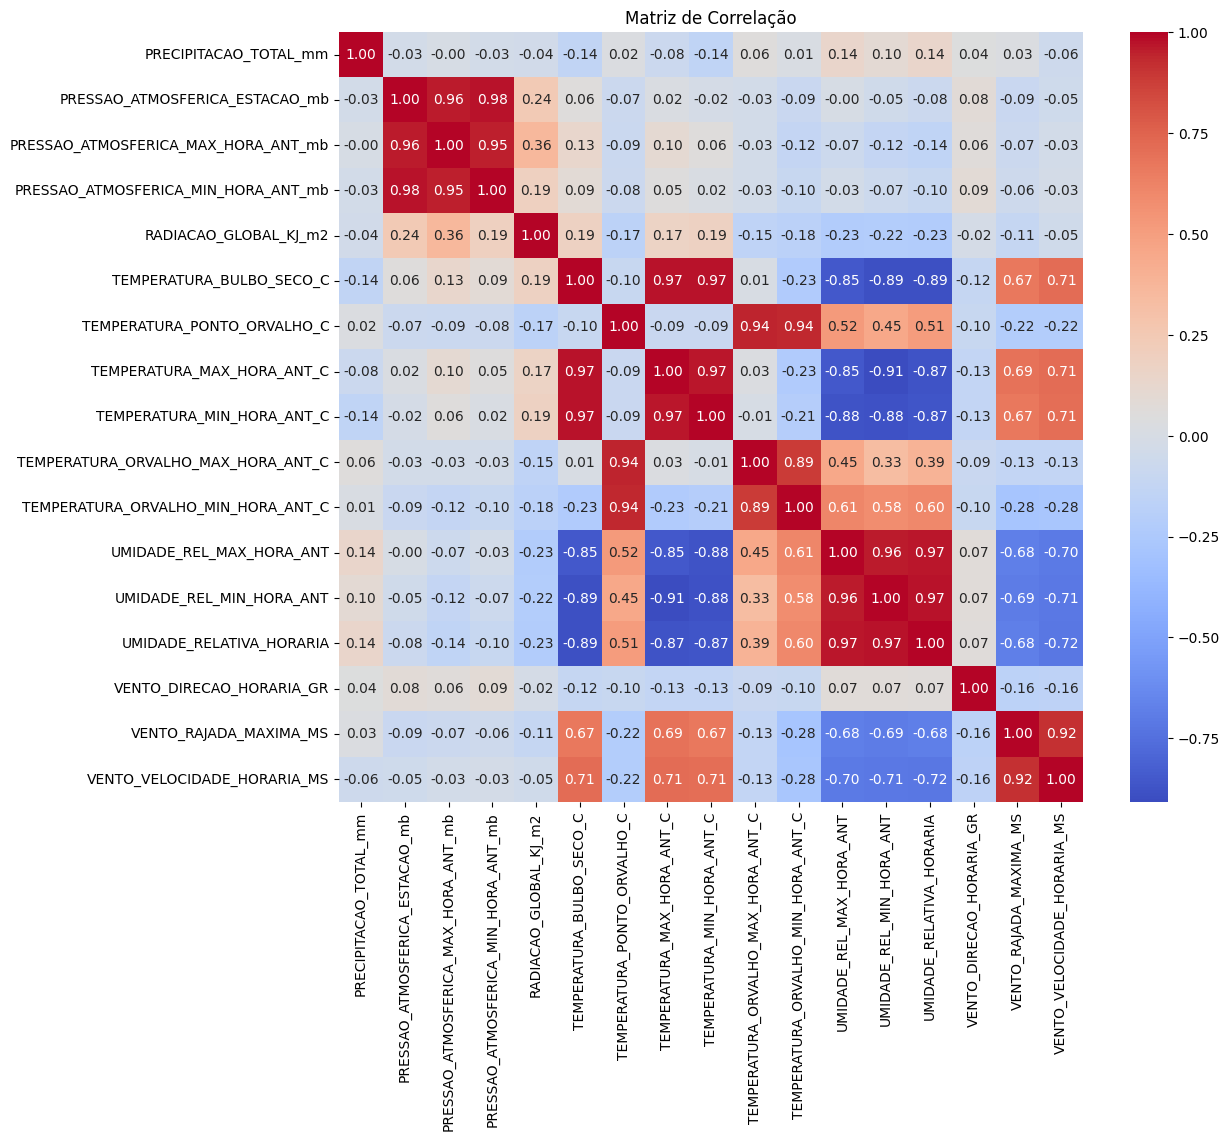

In [14]:
# Cria matriz de correlação
plt.figure(figsize=(12, 10)) # Define tamanho da figura
corr = df_analyses.corr() # Calcula correlações
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm') # Plota heatmap
plt.title("Matriz de Correlação") # Adiciona título
plt.show() # Exibe o gráfico

In [15]:
# Seleciona colunas para modelagem
all_columns = df.columns
if target_column not in all_columns:
    all_columns.append(target_column)
df_model = df[all_columns].copy()

# Converte coordenadas para numérico
for col in ['LATITUDE', 'LONGITUDE', 'ALTURA']:
    if col in df_model.columns:
        df_model[col] = df_model[col].str.replace(',', '.') # Substitui vírgula por ponto
        df_model[col] = pd.to_numeric(df_model[col], errors='coerce') # Converte para número

# Trata valores faltantes
df_model.interpolate(method='linear', inplace=True) # Interpolação linear
df_model.fillna(method='bfill', inplace=True) # Preenchimento backward
df_model.fillna(method='ffill', inplace=True) # Preenchimento forward

C:\Users\renat\AppData\Local\Temp\ipykernel_12692\673723329.py:14: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_model.interpolate(method='linear', inplace=True) # Interpolação linear
C:\Users\renat\AppData\Local\Temp\ipykernel_12692\673723329.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model.fillna(method='bfill', inplace=True) # Preenchimento backward
C:\Users\renat\AppData\Local\Temp\ipykernel_12692\673723329.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model.fillna(method='ffill', inplace=True) # Preenchimento forward


In [16]:
# Remove colunas não numéricas
df_features = df_model.drop(columns=['DATA','FILE'])

# Normaliza os dados

scaler = MinMaxScaler()
values_scaled = scaler.fit_transform(df_features.values)

def create_dataset_multivariate(data, window_size=24, target_idx=0):
    # Cria sequências temporais para LSTM
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size, :]) # Sequência de entrada
        y.append(data[i+window_size, target_idx]) # Valor alvo
    return np.array(X), np.array(y)

# Prepara dados para LSTM

target_idx = df_features.columns.get_loc(target_column)
X, y = create_dataset_multivariate(values_scaled, window_size, target_idx)

In [17]:
# Dividir em treino e teste (80% treino)
split_index = int(len(X)*0.65)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Formato X_train: {X_train.shape}, y_train: {y_train.shape}")


Formato X_train: (114862, 24, 20), y_train: (114862,)


In [18]:
# Construção do modelo LSTM
model = Sequential([
        LSTM(50, activation='relu', # Camada LSTM com 50 unidades
        input_shape=(window_size, X_train.shape[2])),# Define formato de entrada
        Dense(1) # Camada de saída
    ])

# Compilação do modelo
model.compile(optimizer='adam', # Otimizador Adam
loss='mse') # Função de perda MSE

# Configuração do early stopping
early_stop = EarlyStopping(
        monitor='val_loss', # Monitora perda na validação
        patience=10, # Paciência de 10 épocas
        restore_best_weights=True # Restaura melhores pesos
    )

# Treinamento do modelo
history = model.fit(
        X_train, y_train, # Dados de treino
        epochs=epochs, # Número de épocas
        batch_size=32, # Tamanho do batch
        validation_split=0.2, # 20% para validação
        callbacks=[early_stop], # Callbacks
        verbose=1 # Nível de log
    )

c:\Users\renat\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0022 - val_loss: 7.9707e-04
Epoch 2/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.0010 - val_loss: 8.0633e-04
Epoch 3/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 9.7632e-04 - val_loss: 9.3387e-04
Epoch 4/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 9.5853e-04 - val_loss: 7.5697e-04
Epoch 5/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 9.3384e-04 - val_loss: 8.1435e-04
Epoch 6/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 9.0299e-04 - val_loss: 8.0538e-04
Epoch 7/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 8.9411e-04 - val_loss: 7.4756e-04
Epoch 8/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 8.9074e-04 - val_loss: 6.9195e-04
Epoch 9/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 8.5955e-04 - val_loss: 7.4050e-04
Epoch 10/50
2872/2872 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 8.6627e-04 - val_loss: 7.5965e-04
Epoch 11/50
2872/2872 ━━━━━━━━━━━━━━━

1933/1933 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


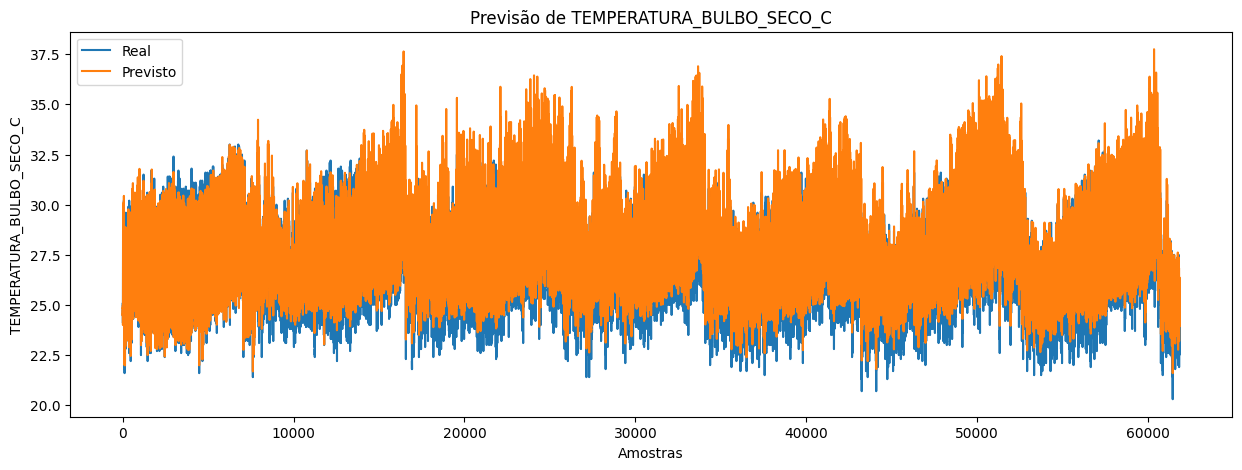

In [19]:
# Faz predições com o modelo
y_pred = model.predict(X_test) # Realiza predições

# Prepara dados para inversão da normalização
y_test_full = np.zeros((y_test.shape[0], values_scaled.shape[1])) # Matriz para teste
y_test_full[:, target_idx] = y_test # Preenche valores de teste
y_test_inv = scaler.inverse_transform(y_test_full)[:, target_idx] # Inverte normalização

# Prepara predições para inversão da normalização
y_pred_full = np.zeros((y_pred.shape[0], values_scaled.shape[1])) # Matriz para predições
y_pred_full[:, target_idx] = y_pred.flatten() # Preenche predições
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, target_idx] # Inverte normalização

# Visualização dos resultados
plt.figure(figsize=(15, 5)) # Define tamanho da figura
plt.plot(y_test_inv, label='Real') # Plota valores reais
plt.plot(y_pred_inv, label='Previsto') # Plota valores previstos
plt.title(f'Previsão de {target_column}') # Adiciona título
plt.xlabel('Amostras') # Rótulo eixo x
plt.ylabel(target_column) # Rótulo eixo y
plt.legend() # Adiciona legenda
plt.show() # Exibe o gráfico

In [20]:
# Cálculo das métricas de erro
mse = mean_squared_error(y_test_inv, y_pred_inv) # Erro quadrático médio
mae = mean_absolute_error(y_test_inv, y_pred_inv) # Erro absoluto médio
print(f'MSE: {mse:.3f}') # Exibe MSE
print(f'MAE: {mae:.3f}') # Exibe MAE

MSE: 1.788
MAE: 0.991


In [21]:
# Salva o modelo treinado
model.save('modelo_lstm_generalizado.h5') # Salva modelo em formato H5

# Salva base de dados normalizada
df.to_csv('base_normalizada.csv', sep=';', index=False) # Salva CSV com dados processados
